In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
csv_modelA = 'test_patient_evaluation_ce.csv'
csv_modelB = 'test_patient_evaluation_pafa.csv'

In [34]:
dfA = pd.read_csv(csv_modelA)
dfB = pd.read_csv(csv_modelB)

In [35]:
print("=== Model A Data Preview ===")
print(dfA.head(), "\n")
print("=== Model B Data Preview ===")
print(dfB.head())

=== Model A Data Preview ===
   patient id  number of samples  accuracy    spesific  sensitive      score
0         101               23.0  1.000000  100.000000   0.000000  50.000000
1         102               13.0  0.923077   92.307692   0.000000  46.153846
2         104               55.0  0.545455   54.545455  54.545455  54.545455
3         109               61.0  0.606557   65.217391  46.666667  55.942029
4         113               50.0  0.680000   68.000000   0.000000  34.000000 

=== Model B Data Preview ===
   patient id  number of samples  accuracy    spesific  sensitive      score
0         101               23.0  1.000000  100.000000   0.000000  50.000000
1         102               13.0  1.000000  100.000000   0.000000  50.000000
2         104               55.0  0.745455   88.636364  18.181818  53.409091
3         109               61.0  0.950820   95.652174  93.333333  94.492754
4         113               50.0  1.000000  100.000000   0.000000  50.000000


In [36]:
def print_accuracy_stats(df, model_name):
    mean_acc = df['accuracy'].mean()
    std_acc  = df['accuracy'].std()
    max_acc  = df['accuracy'].max()
    min_acc  = df['accuracy'].min()
    print(f"--- {model_name} ---")
    print(f"Mean Accuracy: {mean_acc:.4f}")
    print(f"Std Accuracy : {std_acc:.4f}")
    print(f"Max Accuracy : {max_acc:.4f}")
    print(f"Min Accuracy : {min_acc:.4f}\n")
    
print_accuracy_stats(dfA, "Model A")
print_accuracy_stats(dfB, "Model B")

--- Model A ---
Mean Accuracy: 0.7179
Std Accuracy : 0.2092
Max Accuracy : 1.0000
Min Accuracy : 0.2857

--- Model B ---
Mean Accuracy: 0.7234
Std Accuracy : 0.2160
Max Accuracy : 1.0000
Min Accuracy : 0.2857



In [37]:
def accuracy_range_analysis(df, model_name):
    """
    환자별 accuracy를 0~0.1, 0.1~0.2, ... 0.9~1.0 구간으로 나누어 각 구간의 환자 수 및
    상위 10개의 patient id를 출력합니다.
    """
    df = df.copy()
    bins = np.arange(0, 1.1, 0.1)  # 0.0, 0.1, 0.2, ..., 1.0
    labels = [f"{bins[i]:.1f}~{bins[i+1]:.1f}" for i in range(len(bins)-1)]
    
    df['accuracy_range'] = pd.cut(df['accuracy'], bins=bins, labels=labels, include_lowest=True, right=False)
    groups = df.groupby('accuracy_range')
    
    print(f"--- Accuracy Range Analysis for {model_name} ---")
    for rng, group in groups:
        print(f"Range {rng}: {len(group)} patients")
        patient_ids = group['patient id'].tolist()
        print(f"    Patient IDs (first 10): {patient_ids[:10]}")
    print("\n")

    
accuracy_range_analysis(dfA, "Model A")
accuracy_range_analysis(dfB, "Model B")

--- Accuracy Range Analysis for Model A ---
Range 0.0~0.1: 0 patients
    Patient IDs (first 10): []
Range 0.1~0.2: 0 patients
    Patient IDs (first 10): []
Range 0.2~0.3: 1 patients
    Patient IDs (first 10): [182]
Range 0.3~0.4: 1 patients
    Patient IDs (first 10): [118]
Range 0.4~0.5: 6 patients
    Patient IDs (first 10): [145, 147, 149, 150, 205, 218]
Range 0.5~0.6: 7 patients
    Patient IDs (first 10): [104, 146, 156, 160, 195, 198, 223]
Range 0.6~0.7: 10 patients
    Patient IDs (first 10): [109, 113, 139, 151, 169, 173, 174, 175, 177, 178]
Range 0.7~0.8: 7 patients
    Patient IDs (first 10): [124, 133, 176, 185, 207, 216, 224]
Range 0.8~0.9: 4 patients
    Patient IDs (first 10): [165, 170, 211, 214]
Range 0.9~1.0: 2 patients
    Patient IDs (first 10): [102, 143]


--- Accuracy Range Analysis for Model B ---
Range 0.0~0.1: 0 patients
    Patient IDs (first 10): []
Range 0.1~0.2: 0 patients
    Patient IDs (first 10): []
Range 0.2~0.3: 1 patients
    Patient IDs (first 10

/tmp/ipykernel_820/1272095266.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby('accuracy_range')
/tmp/ipykernel_820/1272095266.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby('accuracy_range')


In [38]:
df_compare = pd.merge(dfA[['patient id', 'accuracy']], dfB[['patient id', 'accuracy']], 
                      on='patient id', suffixes=('_A', '_B'))

In [39]:
# 먼저 df_compare에 "number of samples" 컬럼을 포함하여 merge 합니다.
df_compare = pd.merge(dfA[['patient id', 'number of samples', 'accuracy']], 
                      dfB[['patient id', 'accuracy']], 
                      on='patient id', 
                      suffixes=('_A', '_B'))

# 환자별 정확도 차이 계산 (Model B - Model A)
df_compare['accuracy_diff'] = df_compare['accuracy_B'] - df_compare['accuracy_A']

# 개선/감소/변화 없음에 해당하는 마스크 생성
improved_mask = df_compare['accuracy_diff'] > 0
decreased_mask  = df_compare['accuracy_diff'] < 0
nochange_mask   = df_compare['accuracy_diff'] == 0

# 각 카테고리의 환자 수 산출
num_improved = improved_mask.sum()
num_decreased = decreased_mask.sum()
num_nochange  = nochange_mask.sum()
avg_diff      = df_compare['accuracy_diff'].mean()

# 각 카테고리별로 "환자 id (샘플 갯수)" 형태의 문자열을 추출
improved_ids = df_compare.loc[improved_mask].apply(lambda row: f"{row['patient id']} ({row['number of samples']})", axis=1).tolist()
decreased_ids  = df_compare.loc[decreased_mask].apply(lambda row: f"{row['patient id']} ({row['number of samples']})", axis=1).tolist()
nochange_ids   = df_compare.loc[nochange_mask].apply(lambda row: f"{row['patient id']} ({row['number of samples']})", axis=1).tolist()

print("=== Model Comparison (B vs A) ===")
print(f"Number of patients with improved accuracy: {num_improved}")
print(f"Patient IDs with improved accuracy         : {improved_ids}")
print(f"Number of patients with decreased accuracy : {num_decreased}")
print(f"Patient IDs with decreased accuracy          : {decreased_ids}")
print(f"Number of patients with no change          : {num_nochange}")
print(f"Patient IDs with no change                   : {nochange_ids}")
print(f"Average accuracy difference                  : {avg_diff:.4f}\n")

=== Model Comparison (B vs A) ===
Number of patients with improved accuracy: 14
Patient IDs with improved accuracy         : ['102.0 (13.0)', '104.0 (55.0)', '109.0 (61.0)', '113.0 (50.0)', '133.0 (156.0)', '139.0 (46.0)', '147.0 (103.0)', '149.0 (51.0)', '151.0 (168.0)', '174.0 (110.0)', '178.0 (208.0)', '185.0 (55.0)', '198.0 (98.0)', '205.0 (102.0)']
Number of patients with decreased accuracy : 20
Patient IDs with decreased accuracy          : ['118.0 (40.0)', '119.0 (9.0)', '144.0 (20.0)', '145.0 (37.0)', '146.0 (80.0)', '156.0 (61.0)', '160.0 (101.0)', '165.0 (23.0)', '169.0 (14.0)', '170.0 (150.0)', '175.0 (23.0)', '176.0 (133.0)', '177.0 (79.0)', '187.0 (17.0)', '195.0 (75.0)', '207.0 (139.0)', '214.0 (7.0)', '218.0 (59.0)', '223.0 (61.0)', '224.0 (14.0)']
Number of patients with no change          : 15
Patient IDs with no change                   : ['101.0 (23.0)', '123.0 (8.0)', '124.0 (48.0)', '126.0 (11.0)', '136.0 (9.0)', '143.0 (18.0)', '150.0 (17.0)', '171.0 (9.0)', '173.

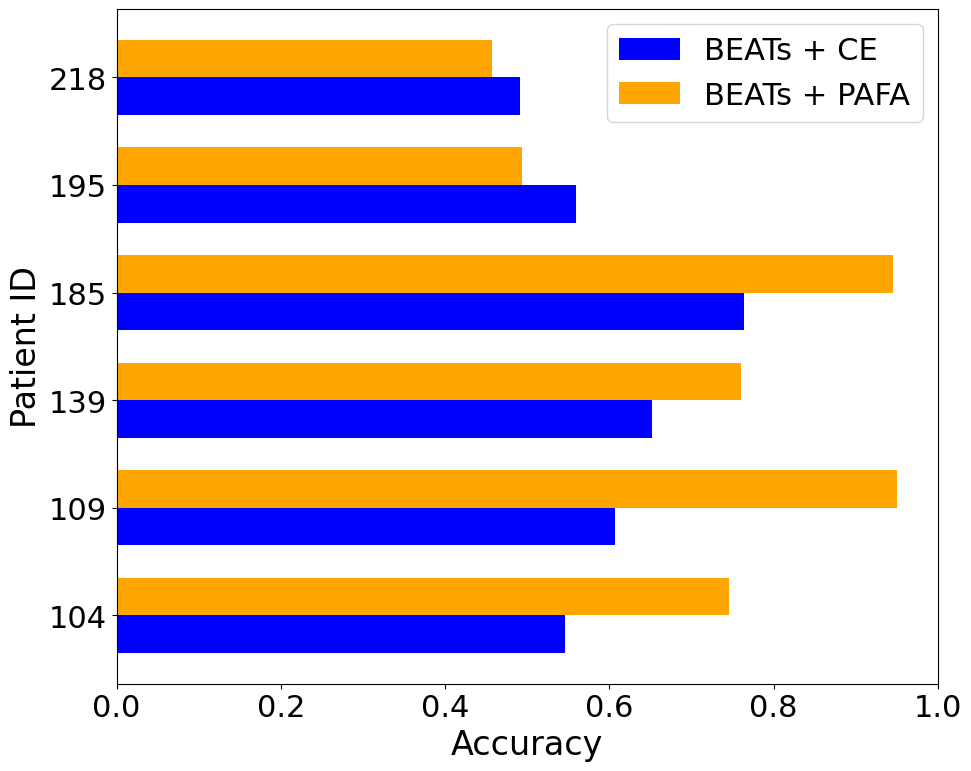

In [40]:
import numpy as np

# selected_ids = [109,218,185,195,139,104,118,124,113] ## sub cluster
selected_ids = [109,218,185,195,139,104] ## sub cluster

# selected_ids = [160,198,146,174,177,145,147,133,176,205] ## High sample
# selected_ids = [160,198,146,174,177,145] ## High sample

# 각 모델별로 선택한 환자 id에 해당하는 데이터 필터링
dfA_selected = dfA[dfA['patient id'].isin(selected_ids)][['patient id', 'accuracy']]
dfB_selected = dfB[dfB['patient id'].isin(selected_ids)][['patient id', 'accuracy']]


# 환자 id를 기준으로 두 모델의 데이터를 merge하여 side-by-side 비교가 가능하도록 함
df_selected = pd.merge(dfA_selected, dfB_selected, on='patient id', suffixes=('_A', '_B'))


# Set font size parameters for various elements
axis_label_font_size = 24   # for x- and y-axis labels
title_font_size       = 28   # for the plot title
tick_label_font_size  = 22   # for the tick labels
legend_font_size      = 22   # for the legend text


plt.figure(figsize=(10, 8))

# 수평 바의 위치 설정. 각 환자마다 두 모델의 정확도를 바 그룹으로 표시합니다.
y_positions = np.arange(len(df_selected))
bar_height = 0.35  # 한 그룹 내 바 높이

# 각 모델의 정확도를 수평 막대로 그림
plt.barh(y_positions - bar_height/2, df_selected['accuracy_A'], height=bar_height, 
         label='BEATs + CE', color='blue')
plt.barh(y_positions + bar_height/2, df_selected['accuracy_B'], height=bar_height, 
         label='BEATs + PAFA', color='orange')

# Axis labels and title with font size adjustments
plt.xlabel('Accuracy', fontsize=axis_label_font_size)
plt.ylabel('Patient ID', fontsize=axis_label_font_size)
# plt.title('Accuracy Comparison for Selected Patients', fontsize=title_font_size)

# Setting tick label sizes for both axes
plt.xticks(fontsize=tick_label_font_size)
plt.yticks(y_positions, df_selected['patient id'], fontsize=tick_label_font_size)

plt.xlim(0, 1)  # 정확도가 0~1 사이의 값일 경우
plt.legend(fontsize=legend_font_size)
plt.tight_layout()
plt.show()

In [41]:
# plt.figure(figsize=(10,5))
# sns.histplot(df_compare['accuracy_diff'], bins=20, kde=True, color='green')
# plt.title("Distribution of Accuracy Difference (Model B - Model A)")
# plt.xlabel("Accuracy Difference")
# plt.ylabel("Number of Patients")
# plt.show()

In [42]:
# plt.figure(figsize=(10,5))
# sns.scatterplot(data=df_compare, x='accuracy_A', y='accuracy_B')
# plt.plot([df_compare['accuracy_A'].min(), df_compare['accuracy_A'].max()],
#          [df_compare['accuracy_A'].min(), df_compare['accuracy_A'].max()],
#          color='red', linestyle='--', label='y=x')
# plt.xlabel("Accuracy (Model A)")
# plt.ylabel("Accuracy (Model B)")
# plt.title("Patient-level Accuracy: Model A vs Model B")
# plt.legend()
# plt.show()

In [43]:
# plt.figure(figsize=(12,6))
# sns.histplot(dfA['accuracy'], bins=10, kde=True, color="blue", label="CE", alpha=0.5)
# sns.histplot(dfB['accuracy'], bins=10, kde=True, color="orange", label="PAFA", alpha=0.5)
# plt.title("Patient-level Accuracy Distribution")
# plt.xlabel("Accuracy")
# plt.ylabel("Count")
# plt.legend()
# plt.show()

In [44]:
# # 모델별 식별을 위한 컬럼 추가
# dfA_plot = dfA[['patient id', 'accuracy']].copy()
# dfA_plot['Model'] = 'CE'

# dfB_plot = dfB[['patient id', 'accuracy']].copy()
# dfB_plot['Model'] = 'PAFA'

# # 두 데이터프레임 합치기
# df_all = pd.concat([dfA_plot, dfB_plot], ignore_index=True)

# # 폰트 크기 설정
# plt.rcParams.update({'font.size': 16})

# plt.figure(figsize=(10, 6))
# sns.boxplot(data=df_all, x='Model', y='accuracy', palette='Set2')
# sns.stripplot(data=df_all, x='Model', y='accuracy', color='gray', jitter=True, alpha=0.7)
# plt.title('Patient-level Accuracy Distribution')
# plt.xlabel('Method')
# plt.ylabel('Accuracy')
# plt.ylim(0, 1.05)

# plt.xticks(fontsize=18)
# plt.yticks(fontsize=14)

# plt.show()